# [LSTM Monthly Temperature Prediction Example](https://github.com/chrizchow/MLHelloWorld/blob/main/LSTMPyTorch/LSTMTemperaturePrediction.ipynb)

Most of the time, the weather of one city is heavily related to its weather in the past. In fact, the weather should follow some seasonal patterns. Hence, in this example, we use Long-Short-Term-Memory Neural Network (LSTM) to find this hidden seasonal pattern in the temperature, and then make some sensible predictions for the future.

Reference:
- [Time Series Prediction with LSTM](https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python)
- [Weather Forecasting with RNN](https://medium.com/analytics-vidhya/weather-forecasting-with-recurrent-neural-networks-1eaa057d70c3)
- [PyTorch LSTM Manual](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)


Import related libraries:

In [11]:
'''Train with PyTorch.'''
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import torch.utils.data as data

# SciKit
from sklearn.preprocessing import MinMaxScaler

# Python
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt

Declaring machine learning parameters:

In [12]:
# ML Parameters
lr = 1e-3
epoch = 10
batch_size = 360

# Input Dataset
input_dataset_file = './station/466920taipei_train.csv'

# Normalization
scaler = MinMaxScaler(feature_range=(-1, 1))


Check if Pandas can read the dataset correctly:

In [13]:
# Load Dataset
df = pd.read_csv(input_dataset_file, usecols = ["觀測時間(hour)", "測站氣壓(hPa)", "海平面氣壓(hPa)", "氣溫(℃)", "露點溫度(℃)", "相對溼度(%)", "風速(m/s)", "降水量(mm)", "降水時數(hr)", "日照時數(hr)", "天全空日射量(MJ/㎡)"], header=0)
df.head()

,觀測時間(hour),測站氣壓(hPa),海平面氣壓(hPa),氣溫(℃),露點溫度(℃),相對溼度(%),風速(m/s),降水量(mm),降水時數(hr),日照時數(hr),天全空日射量(MJ/㎡)
0,2010/1/1 00:00,1021.8,1022.6,13.7,8.2,69.0,3.6,0.0,0.0,NaN,0.0
1,2010/1/1 01:00,1021.4,1022.2,13.8,8.3,69.0,4.0,0.0,0.0,NaN,0.0
2,2010/1/1 02:00,1020.4,1021.2,13.9,8.4,69.0,3.8,0.0,0.0,NaN,0.0
3,2010/1/1 03:00,1019.9,1020.7,13.9,8.4,69.0,4.1,0.0,0.0,NaN,0.0
4,2010/1/1 04:00,1019.6,1020.4,14.0,8.5,69.0,3.3,0.0,0.0,NaN,0.0


Take 70% of data as training set, and 30% of data as validation set:

Make it as PyTorch Dataset Class. This class assumes **the data is previous X month temperature, and the target is the 6th month temperature**:

[$t_1$ $t_2$ $t_3$ $t_4$ $t_5$ ... $t_x$] --> [$t_{x+1}$]

[$t_2$ $t_3$ $t_4$ $t_5$ ... $t_{x+1}$] --> [$t_{x+2}$]

...

[$t_{n-5}$ $t_{n-4}$ $t_{n-3}$ $t_{n-2}$ $t_{n-1}$ ... $t_{x+1-n}$] --> [$t_n$]


In [14]:
df = pd.read_csv(input_dataset_file, usecols = ["觀測時間(hour)", "氣溫(℃)"], header=0)
orig_dataset = df["氣溫(℃)"].to_numpy()  # temperature

# store another normalized dataset
normalized_dataset = np.copy(orig_dataset)  
normalized_dataset = normalized_dataset.reshape(-1)

# normalized_dataset = scaler.fit_transform(normalized_dataset)

# print(type(normalized_dataset))
# print(normalized_dataset)

In [15]:
class TemperatureDataset(data.Dataset):

    def __init__(self, file):
        
        # read CSV
        self.df = pd.read_csv(file, usecols = ["觀測時間(hour)", "氣溫(℃)"], header=0)
        self.orig_dataset = df["氣溫(℃)"].to_numpy()  # temperature
        
        # store another normalized dataset
        self.normalized_dataset = np.copy(self.orig_dataset)  
        self.normalized_dataset = self.normalized_dataset.reshape(-1, 1)  # (row, column): -1:不限;1:一(直)行

        # calculate normalization
        self.normalized_dataset = scaler.fit_transform(self.normalized_dataset)  # normalize氣溫至-1~1
        self.normalized_dataset = self.normalized_dataset.reshape(-1)  # 變成一維
        
        # use X history data (X months) generate one target 
        self.sample_len = 168  # 用168 hours預測未來一小時的氣溫

    def __len__(self):
        # 回傳資料長度
        
        if len(self.orig_dataset) > self.sample_len:
            return len(self.orig_dataset) - self.sample_len
        else:
            return 0

    def __getitem__(self, idx):
        # 用索引值取得資料
        
        # target is the last records
        target = self.normalized_dataset[self.sample_len+idx]  # 第X+1個月
        target = np.array(target).astype(np.float64)  # convert to numpy array
        
        # data is the previous five records
        i = self.normalized_dataset[idx:(idx+self.sample_len)]

        # LSTM requires time-series data to shape in this way
        i = i.reshape((-1, 1))
        
        # convert to PyTorch tensors
        i = torch.from_numpy(i)
        target = torch.from_numpy(target)
        
        return i, target


Preparation of training and validation set:

**DataLoader** 把dataset轉換為iteration

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load dataset
dataset = TemperatureDataset(input_dataset_file)

# Split training and validation set
train_len = int(0.7*len(dataset))
valid_len = len(dataset) - train_len
TrainData, ValidationData = random_split(dataset,[train_len, valid_len])

# Load into Iterator (each time get one batch)
train_loader = data.DataLoader(TrainData, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = data.DataLoader(ValidationData, batch_size=batch_size, shuffle=True, num_workers=0)

# Print statistics
print("Total: ", len(dataset))
print("Training Set: ", len(TrainData))
print("Validation Set: ", len(ValidationData))


Total:  96192
Training Set:  67334
Validation Set:  28858


Our Machine Learning model is a Fully-Connected LSTM:

In [17]:
class TempLSTM(nn.Module):

    def __init__(self):

        # Required in PyTorch Model
        super(TempLSTM, self).__init__()
        
        # Parameters
        self.feature_dim = 1
        self.hidden_size = 100
        self.num_layers = 1
        self.output_dim = 1

        # Neural Networks
        self.lstm = nn.LSTM(self.feature_dim, self.hidden_size, self.num_layers, dropout=0.1, batch_first=True)
        self.fc = nn.Linear(self.hidden_size , self.output_dim)
        
    def forward(self, i):

        # Set initial hidden and cell states
        h0 = torch.zeros([self.num_layers, i.shape[0], self.hidden_size], dtype=torch.double).to(i.device) #.requires_grad_()
        c0 = torch.zeros([self.num_layers, i.shape[0], self.hidden_size], dtype=torch.double).to(i.device) #.requires_grad_()

        # Forward propagate LSTM
        # detach() is used to prevent backpropagating to the start of the sequence
        # _是隱藏狀態(這邊不需要)
        out, _ = self.lstm.forward(i, (h0.detach(), c0.detach()))  # output shape (batch, sequence, hidden_dim)
        out = self.fc(out[:, -1, :])  # 只取最後一個時間點的output
        return out

Define and build machine learning model:

In [18]:
# Define model
model = TempLSTM()
model = model.double()
print(model)

# Load into GPU if necessary
model = model.to(device)

# Define loss function
criterion = nn.MSELoss()

# Define optimization strategy
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


TempLSTM(
  (lstm): LSTM(1, 100, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)


c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Training and Testing Functions:

In [19]:
###########################
# Train with training set #
###########################
train_loss_list = []
def train(model, iterator, optimizer, criterion, device):
    
    model.train()     # Enter Train Mode
    train_loss = 0

    for _, (ii, targets) in enumerate(iterator):
        
        # move to GPU if necessary
        # ii: input datas / targets: target data(ii要預測的氣溫)
        ii, targets = ii.to(device), targets.to(device)
        
        # generate prediction
        optimizer.zero_grad()  # clear gradients (before update weights)
        preds = model(ii)
        preds = preds.view(-1)  # 改為一維
        
        # calculate loss
        loss = criterion(preds, targets)

        # compute gradients and update weights
        loss.backward()  # 將loss向input反向傳播
        optimizer.step()  # 更新weight
        
        # record training losses
        train_loss += loss.item()

    # print completed result
    print('train_loss: %f' % (train_loss))
    train_loss_list.append(train_loss)
    return train_loss


#############################
# Validate with testing set #
#############################
test_loss_list = []
def test(model, iterator, criterion, device):

    model.eval()     # Enter Evaluation Mode
    test_loss = 0

    with torch.no_grad():
        for _, (ii, targets) in enumerate(iterator):

            # move to GPU if necessary
            ii, targets = ii.to(device), targets.to(device)
            
            # generate prediction
            preds = model(ii)
            preds = preds.view(-1)
            
            # convert target tensor to long
            targets = targets.long()
            
            # calculate loss
            loss = criterion(preds, targets)
            
            # record training losses
            test_loss += loss.item()
    
    # print completed result
    print('test_loss: %s' % (test_loss))
    test_loss_list.append(test_loss)
    return test_loss


##################################
# Use the model to do prediction #
##################################
def predict(model, device, data):
    model.eval()     # Enter Evaluation Mode
    with torch.no_grad():
        pred = model(data)
        return pred


Acutal execution:

- Run `training()` and `test()` for `epoch` times
- Save best results information


In [20]:
# Running
for epoch in range(epoch):
    print("===== Epoch %i =====" % epoch)
    train(model, train_loader, optimizer, criterion, device)
    test(model, test_loader, criterion, device)

===== Epoch 0 =====
train_loss: 4.341229
test_loss: 9.008056189372128
===== Epoch 1 =====
train_loss: 1.320598
test_loss: 10.064567875384828
===== Epoch 2 =====
train_loss: 0.520915
test_loss: 10.737076491069946
===== Epoch 3 =====
train_loss: 0.383872
test_loss: 10.1919291252311
===== Epoch 4 =====
train_loss: 0.314379
test_loss: 10.677182898984737
===== Epoch 5 =====
train_loss: 0.287567
test_loss: 10.67765999203693
===== Epoch 6 =====
train_loss: 0.267623
test_loss: 10.518411087706411
===== Epoch 7 =====
train_loss: 0.259024
test_loss: 10.163511939532007
===== Epoch 8 =====
train_loss: 0.249407
test_loss: 10.283697201545472
===== Epoch 9 =====
train_loss: 0.242953
test_loss: 9.982006274344732


視覺化loss

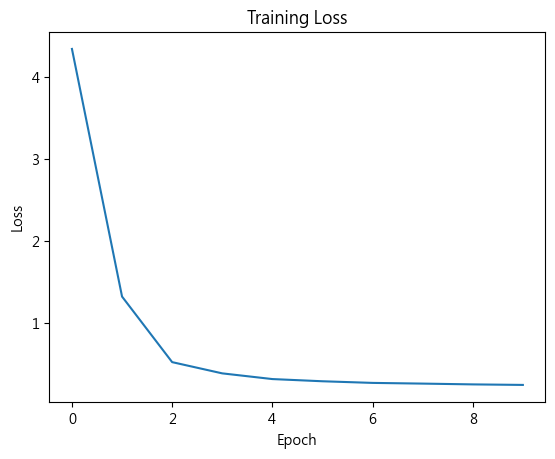

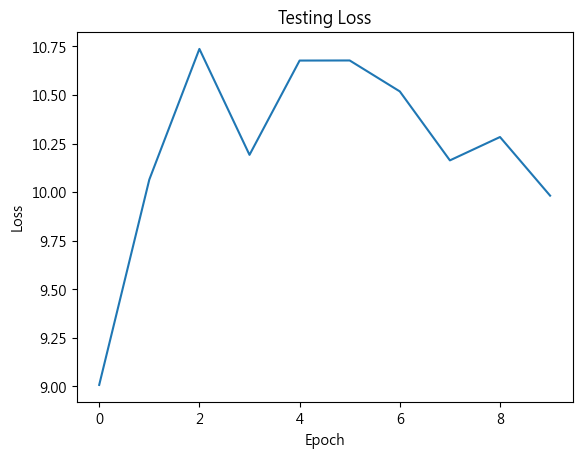

In [21]:
import matplotlib.pyplot as plt

def plot_train_loss(train_loss_list):
    plt.figure()
    plt.plot(range(len(train_loss_list)), train_loss_list)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

def plot_test_loss(test_loss_list):
    plt.figure()
    plt.plot(range(len(test_loss_list)), test_loss_list)
    plt.title('Testing Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

plot_train_loss(train_loss_list)
plot_test_loss(test_loss_list)

Use the trained model to predict temperature:

In [23]:
# Predicting N months
N = 12  # 預測未來N個月的氣溫

# pred dataset
pred_dataset_file = './station/466920taipei_test.csv'
test_dataset = TemperatureDataset(pred_dataset_file)

df = pd.read_csv(pred_dataset_file, usecols = ["觀測時間(hour)", "氣溫(℃)"], header=0)

# Extract the second column
mean_temps = df["氣溫(℃)"]

# Pick P points randomly in data as starting
P = 10  # 10組prediction
# points = np.random.randint(dataset.sample_len, high=len(dataset), size=P)  # 隨機抓每一組的預測起始點
points = np.random.randint(test_dataset.sample_len, high=8760, size=P)  # 隨機抓每一組的預測起始點
preds = np.zeros((P, N))

# Forcast temperature for N months
for idx_i, i in enumerate(points):
    # normalized_temp, target = dataset[i]
    normalized_temp, target = test_dataset[i]
    temperatures = normalized_temp
    temperatures = temperatures.to(device)
    
    for idx_j, j in enumerate(range(N)):
        
        # ii = temperatures.view(1, dataset.sample_len+idx_j, 1).to(device)   # transform into (batch, sequence, features)
        ii = temperatures.view(1, test_dataset.sample_len+idx_j, 1).to(device)   # transform into (batch, sequence, features)
        model = model.to(device)
        pred = predict(model, device, ii).to(device)
        preds[idx_i][idx_j] = pred

        # remove first temp and append predicted data at last
        # temperatures = torch.cat((temperatures[1:], pred.view(-1)))
        temperatures = torch.cat((temperatures, pred))
    
    # Inverse transform the predictions
    actual_predictions = scaler.inverse_transform(preds[idx_i].reshape(-1, 1))  # 從normalization轉為原始氣溫值  
    preds[idx_i] = actual_predictions.reshape(-1)
    print("Predicts: ", actual_predictions)
    print("Expected: ", scaler.inverse_transform(target.reshape(-1, 1)))

Predicts:  [[23.74644664]
 [23.43491854]
 [23.17616014]
 [22.95639225]
 [22.75455853]
 [22.54589577]
 [22.30562817]
 [22.01476761]
 [21.66871172]
 [21.28713744]
 [20.9210523 ]
 [20.65085702]]
Expected:  [[24.]]
Predicts:  [[23.37013792]
 [23.00897786]
 [22.63627296]
 [22.32977659]
 [22.18511408]
 [22.29366174]
 [22.70357951]
 [23.38178303]
 [24.19942788]
 [24.96229072]
 [25.48531507]
 [25.67112733]]
Expected:  [[23.4]]
Predicts:  [[20.32242786]
 [20.41858771]
 [20.47992066]
 [20.49444548]
 [20.45997895]
 [20.38395314]
 [20.27852754]
 [20.15638723]
 [20.02807891]
 [19.90080259]
 [19.77833215]
 [19.66172415]]
Expected:  [[21.]]
Predicts:  [[25.45413542]
 [25.05737548]
 [24.75772975]
 [24.52704582]
 [24.32947011]
 [24.12785098]
 [23.88652996]
 [23.57668735]
 [23.18551379]
 [22.72809168]
 [22.25794635]
 [21.869385  ]]
Expected:  [[25.6]]
Predicts:  [[20.07557373]
 [20.46706944]
 [20.92231048]
 [21.33677634]
 [21.6084814 ]
 [21.68288082]
 [21.5656396 ]
 [21.30575649]
 [20.96842042]
 [20.613

Visualize the prediction results:

Predicted months:  range(7530, 7542)
Predicted months:  range(7274, 7286)
Predicted months:  range(7783, 7795)
Predicted months:  range(7290, 7302)
Predicted months:  range(2334, 2346)
Predicted months:  range(7269, 7281)
Predicted months:  range(2898, 2910)
Predicted months:  range(6604, 6616)
Predicted months:  range(4450, 4462)
Predicted months:  range(6215, 6227)


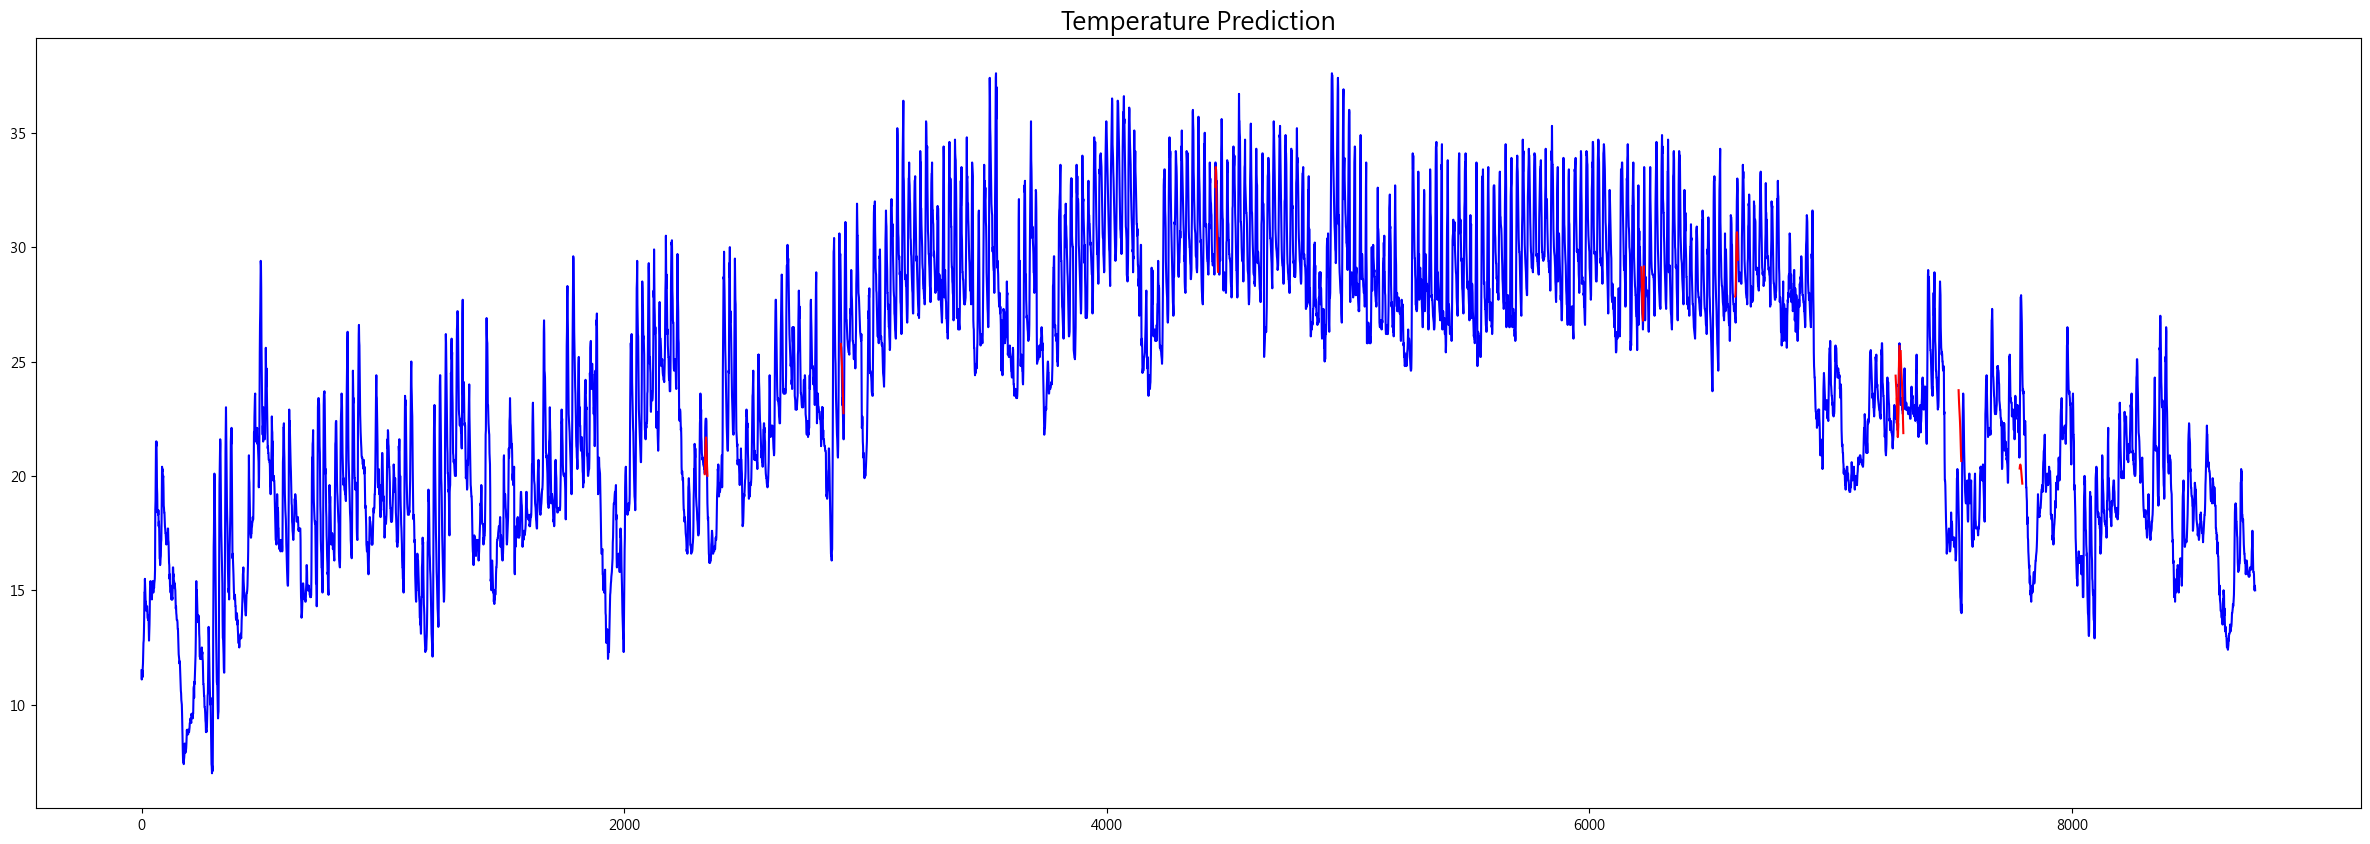

In [24]:
import matplotlib.pyplot as plt

# Data
months = range(0, df["觀測時間(hour)"].size)

# Draw Inline
%matplotlib inline

# Draw Original Lines
plt.figure(figsize = (30,10))
plt.title('Temperature Prediction', fontsize=18)
plt.plot(months, mean_temps, color='b')

# Draw all predicted points
for idx_i, i in enumerate(points):
    i_months = range(i, i+N)
    i_temps = preds[idx_i]
    plt.plot(i_months, i_temps, color='r')
    print("Predicted months: ", i_months)

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Assuming mean_temps, points, preds, and N are defined somewhere above

# Flatten the predictions
flat_preds = [temp for sublist in preds for temp in sublist]

# Select the actual values corresponding to the predictions
y_true = [mean_temps[i:i+N] for i in points]
y_true = [temp for sublist in y_true for temp in sublist]

# Select the part of y_pred to match the length of y_true
y_pred = flat_preds[:len(y_true)]

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

MAE: 1.9151583595945225
MSE: 8.820900904378677
RMSE: 2.9700001522522985
R2: 0.6034638146861775
